In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#sklearn
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

#qiskit
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, TwoLocal, RealAmplitudes
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC, NeuralNetworkClassifier 
from qiskit.aqua.algorithms import VQC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.algorithms.optimizers import SPSA, L_BFGS_B, COBYLA
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from IPython.display import clear_output
from typing import Union

import warnings
warnings.filterwarnings('ignore')

In [3]:
pip install qiskit

Note: you may need to restart the kernel to use updated packages.


In [2]:
import qiskit

print(qiskit.__qiskit_version__)


AttributeError: module 'pyximport.pyximport' has no attribute 'get_distutils_extension'

In [3]:
import pandas as pd
data = pd.read_csv('concatenated_features_cnn_swin.csv')

## Feature selection

In [3]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.decomposition import PCA
data_shuffled = data.sample(frac=1, random_state=1)  # frac=1 shuffles all rows, random_state for reproducibility
# Take only 100 rows
data_n = data_shuffled.head(100)

X = data_n.iloc[:, :-1]  # Select all columns except the last one as features
y= data_n.iloc[:, -1] 
# Perform PCA on the features
pca = PCA(n_components=2)  # Set the desired number of components
X_pca = pca.fit_transform(X)

In [4]:
from operator import itemgetter
features = X.columns.to_list()
for x, y in (sorted(zip(selector.ranking_ , features), key=itemgetter(0))):
    print(x, y)

NameError: name 'selector' is not defined

# Classical classifiers 

## SVM

In [5]:
# classical SVM
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.20, random_state=42)

# Create svm Classifier
ClassifierSVM = SVC()

# Train the model using the training set
ClassifierSVM.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = ClassifierSVM.predict(X_test)

# Model Accuracy: 
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9651860744297719


### SVM performance

In [6]:
# classification report of SVM
expected_y  = y_test
predicted_y = ClassifierSVM.predict(X_test) 

# print classification report and confusion matrix for svm classifier
print("Classification report: \n", metrics.classification_report(expected_y, predicted_y))
print("Confusion matrix: \n", metrics.confusion_matrix(expected_y, predicted_y))

Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       451
           1       0.95      0.98      0.96       382

    accuracy                           0.97       833
   macro avg       0.96      0.97      0.97       833
weighted avg       0.97      0.97      0.97       833

Confusion matrix: 
 [[431  20]
 [  9 373]]


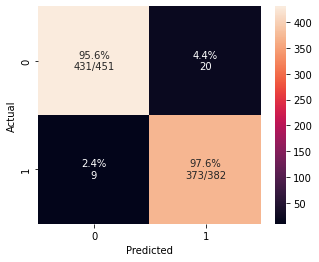

In [7]:
# confusion matrix of SVM
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 
    
cm_analysis(y_test, predicted_y, labels=[0,1], ymap=None, figsize=(5,4)) 

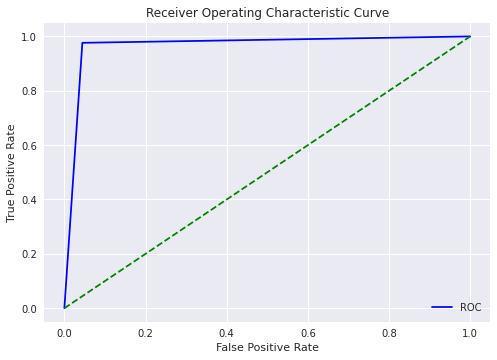

In [8]:
# ROC curve of SVM
plt.style.use('seaborn')

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
fper, tper, thresholds = roc_curve(expected_y, predicted_y)
plot_roc_curve(fper, tper)

## ANN

In [9]:
# classical QNN 
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.20, random_state=42)

model = MLPClassifier(max_iter=1000,  random_state=5)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

Final prediction score: [0.96878752]


In [10]:
# classification report of ANN
expected_y  = y_test
predicted_y = model.predict(X_test) 

# print classification report and confusion matrix for the classifier
print("Classification report: \n", metrics.classification_report(expected_y, predicted_y))
print("Confusion matrix: \n", metrics.confusion_matrix(expected_y, predicted_y))

Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       451
           1       0.96      0.98      0.97       382

    accuracy                           0.97       833
   macro avg       0.97      0.97      0.97       833
weighted avg       0.97      0.97      0.97       833

Confusion matrix: 
 [[434  17]
 [  9 373]]


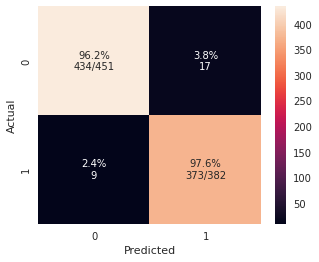

In [11]:
# confusion matrix of ANN
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 
    
cm_analysis(y_test, predicted_y, labels=[0,1], ymap=None, figsize=(5,4)) 

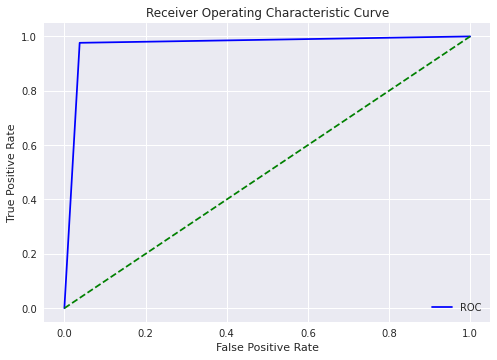

In [12]:
# ROC curve of ANN
plt.style.use('seaborn')

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
fper, tper, thresholds = roc_curve(expected_y, predicted_y)
plot_roc_curve(fper, tper)

# Quantum classifiers 

   ## QSVC

In [2]:
from sklearn.utils import shuffle
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import pandas as pd

# Assuming 'data' is your DataFrame containing the dataset

# Shuffle the data

# Reduce the number of rows to 100 from the shuffled data

# Separate features (X) and target variable (y) from the reduced data
X = data.iloc[:, :-1]  # Select all columns except the last one as features
y = data.iloc[:, -1]  # Assuming the last column is the target variable

# Perform PCA on the features
pca = PCA(n_components=128)  # Set the desired number of components
X_pca = pca.fit_transform(X)

# Now you can proceed with feature selection or any other analysis using X_pca and y


NameError: name 'data' is not defined

In [30]:
data_n

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC120.1,PC121.1,PC122.1,PC123.1,PC124.1,PC125.1,PC126.1,PC127.1,PC128.1,label
3454,3.583592,2.521701,-0.382718,-0.135106,0.310085,-0.422561,-0.168491,-0.083922,0.311952,0.065944,...,0.019128,0.061088,-0.109232,-0.081405,-0.050429,0.227663,0.020532,-0.099801,0.072948,1
739,-1.918987,-0.586743,-2.750916,0.632042,-0.110935,-0.251041,-0.367785,0.276916,-0.070434,0.047561,...,0.006385,0.034735,-0.092897,-0.067789,-0.088055,0.151430,0.027083,0.187157,-0.112673,0
931,-2.516432,0.376088,-1.166978,-0.986172,0.091862,-0.112201,0.374170,-0.166920,0.114629,0.027746,...,-0.025721,-0.000727,-0.053042,-0.011339,0.030807,-0.076416,-0.023686,0.104610,-0.000534,0
960,-3.361100,3.649252,0.804329,-0.777196,0.120017,-0.051293,-0.524477,0.153236,0.230803,-0.029652,...,-0.009287,-0.086826,-0.055974,-0.023647,0.015058,-0.081223,0.062124,0.005443,0.008449,0
1988,-3.085763,-0.867904,-2.049918,0.524231,-0.162299,-0.445129,-0.067202,0.413649,-0.311307,0.083387,...,0.085926,0.032270,-0.087252,0.030409,-0.020976,-0.060150,0.182161,-0.048156,0.065531,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3613,1.351254,-0.505717,-0.156549,-0.091493,0.020775,0.017928,-0.151418,0.021256,0.069756,0.237369,...,-0.050048,-0.054067,-0.051916,-0.064159,-0.105349,-0.104438,-0.014449,0.036273,-0.033472,1
2635,2.901931,2.600149,-0.402842,-0.504015,0.006714,0.054235,-0.032766,-0.121891,-0.094163,0.171103,...,-0.095164,-0.095102,0.066352,0.070945,-0.168612,0.026129,-0.067744,0.015728,0.023667,1
1237,-3.548617,1.382013,2.246261,0.745705,0.031244,-0.107727,-0.006113,0.248546,0.581318,-0.191472,...,0.078072,-0.011857,0.030637,0.035196,-0.051578,-0.025196,-0.003201,0.103955,-0.020881,0
2119,-4.249886,-1.876869,1.424715,0.025006,-0.305107,0.149872,-0.073693,0.048043,-0.201517,0.216553,...,-0.062180,0.024318,0.016553,0.061735,0.084180,0.016001,-0.077091,0.013017,-0.014158,0


In [4]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.decomposition import PCA
data_shuffled = data.sample(frac=1, random_state=1)  # frac=1 shuffles all rows, random_state for reproducibility
# Take only 100 rows
data_n = data_shuffled.head(100)

X = data_n.iloc[:, :-1]  # Select all columns except the last one as features
y= data_n.iloc[:, -1] 
# Perform PCA on the features
pca = PCA(n_components=20)  # Set the desired number of components
X_pca = pca.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.20, random_state=42)

samples = np.append(X_train, X_test, axis=0)
minmax_scaler = MinMaxScaler((0, 1)).fit(samples)
X_train = minmax_scaler.transform(X_train)
X_test = minmax_scaler.transform(X_test)

In [6]:
X_train

array([[0.66001399, 0.56918987, 0.2972276 , ..., 0.29819715, 0.48010874,
        0.4246076 ],
       [0.45334255, 0.06500888, 0.59901993, ..., 0.49206712, 0.30201836,
        0.51088416],
       [0.77946617, 0.72008555, 0.27478739, ..., 0.33513424, 0.32780967,
        0.65396042],
       ...,
       [0.37570617, 0.17768327, 0.70950026, ..., 0.35481218, 0.28425617,
        0.51513907],
       [0.66829181, 0.59431388, 0.57217894, ..., 0.33940726, 0.46523471,
        0.42128217],
       [0.48053384, 0.        , 0.08674917, ..., 0.41690342, 0.        ,
        0.48850001]])

In [7]:
# number of qubits is equal to the number of features
num_qubits = 20
# regularization parameter
C = 1000

In [8]:
algorithm_globals.random_seed = 12345

backend = QuantumInstance(
    Aer.get_backend("qasm_simulator"),
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=2)
qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)
qsvc = QSVC(quantum_kernel=qkernel, C=C)

In [9]:
# training
qsvc.fit(X_train,y_train)

# testing
qsvc_score = qsvc.score(X_test, y_test)
print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.9


In [9]:
y_test

1216    0
990     0
2594    1
3179    1
965     0
2823    1
2500    1
1459    0
123     0
3454    1
1126    0
3521    1
3843    1
2586    1
3479    1
1988    0
1520    0
3723    1
1333    0
3920    1
Name: label, dtype: int64

### QSVC performance

In [10]:
# classification report of QSVC
expected_y  = y_test
predicted_y = qsvc.predict(X_test) 

# print classification report and confusion matrix for the classifier
print("Classification report: \n", metrics.classification_report(expected_y, predicted_y))
print("Confusion matrix: \n", metrics.confusion_matrix(expected_y, predicted_y))

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.85      1.00      0.92        11

    accuracy                           0.90        20
   macro avg       0.92      0.89      0.90        20
weighted avg       0.92      0.90      0.90        20

Confusion matrix: 
 [[ 7  2]
 [ 0 11]]


In [11]:
predicted_y

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1])

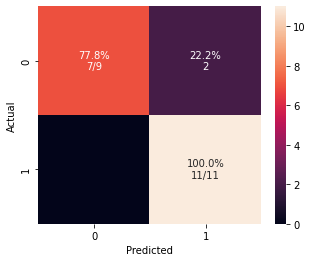

In [12]:
# confusion matrix of QSVC
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 
    
cm_analysis(y_test, predicted_y, labels=[0,1], ymap=None, figsize=(5,4)) 

In [17]:
predicted_y

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1])

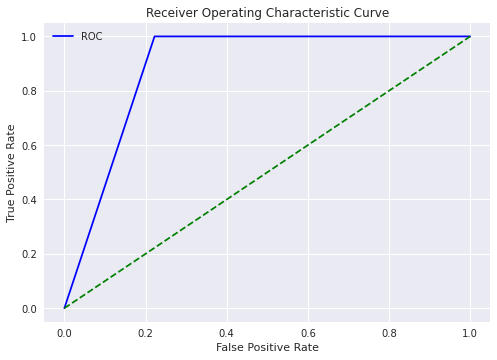

In [18]:
# ROC curve of QSVC
plt.style.use('seaborn')

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
fper, tper, thresholds = roc_curve(expected_y, predicted_y)
plot_roc_curve(fper, tper)

## QNN

In [34]:
algorithm_globals.random_seed = 42
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [23]:
pip install qiskit-aer

Note: you may need to restart the kernel to use updated packages.


In [35]:


from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.decomposition import PCA
data_shuffled = data.sample(frac=1, random_state=1)  # frac=1 shuffles all rows, random_state for reproducibility
# Take only 100 rows
data_n = data_shuffled.head(100)

X = data_n.iloc[:, :-1]  # Select all columns except the last one as features
y= data_n.iloc[:, -1] 
# Perform PCA on the features
pca = PCA(n_components=2)  # Set the desired number of components
X_pca = pca.fit_transform(X)
# for cross validation
X_df = pd.DataFrame(X_pca, columns = ['A','B'])
num_inputs = 2

In [16]:
len(y)

100

In [36]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [37]:
# Classification with a CircuitQNN
# construct feature map
feature_map = ZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=2) 

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose()

In [38]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping

In [39]:
# construct QNN
circuit_qnn = CircuitQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    quantum_instance=quantum_instance,
)

In [40]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(
            neural_network=circuit_qnn, optimizer= L_BFGS_B(), loss='absolute_error', callback=callback_graph
)

In [48]:
x_train[0]

KeyError: 0

In [47]:
y_train

3454    1
739     0
931     0
960     0
1988    0
       ..
3613    1
2635    1
1237    0
2119    0
557     0
Name: label, Length: 87, dtype: int64

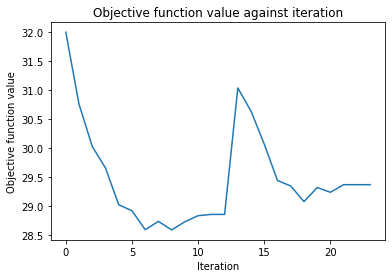

Fold 2 prediction score: 0.5454545454545454


KeyError: 0

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from sklearn.metrics import accuracy_score
objective_func_vals = []
# Assuming you have defined circuit_classifier and X_df (features) and y (target) dataframes

# Reset index of y to ensure alignment with X_df
y.reset_index(drop=True, inplace=True)

kf = KFold(n_splits=3, shuffle=True, random_state=1)
scores = []
for i, (train_index, test_index) in enumerate(kf.split(X_df)):
    x_train = X_df.iloc[train_index]
    x_test = X_df.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    circuit_classifier.fit(x_train, y_train)
    y_pred = circuit_classifier.predict(x_test)
    
    print(f'Fold {i+1} prediction score: {accuracy_score(y_test, y_pred)}')
    scores.append(accuracy_score(y_test, y_pred))

print('Average prediction score:', np.mean(scores))


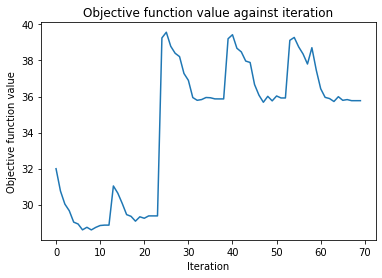

Prediction score: 0.65


In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from sklearn.metrics import accuracy_score

# Assuming you have defined circuit_classifier and X_df (features) and y (target) dataframes
# Reset index of y to ensure alignment with X_df
y.reset_index(drop=True, inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=1)

# Initialize and fit your classifier
circuit_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = circuit_classifier.predict(X_test)

# Calculate and print the prediction score
prediction_score = accuracy_score(y_test, y_pred)
print('Prediction score:', prediction_score)


In [32]:
y_test

80    0
84    1
33    1
81    1
93    1
17    0
36    0
82    0
69    1
65    1
92    0
39    1
56    1
52    0
51    1
32    1
31    1
44    0
78    0
10    0
Name: label, dtype: int64

In [31]:
y_pred

array([1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0])

In [42]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create the ensemble classifier using VotingClassifier
ensemble_classifier = VotingClassifier(estimators=[('qc1', qsvc), ('qc2', circuit_classifier)], voting='soft')

# Fit the ensemble classifier on the training data
ensemble_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ensemble_classifier.predict(X_test)

# Calculate and print the prediction score
prediction_score = accuracy_score(y_test, y_pred)
print('Ensemble prediction score:', prediction_score)

TypeError: Cannot clone object '<qiskit_machine_learning.algorithms.classifiers.neural_network_classifier.NeuralNetworkClassifier object at 0x7f70b3237390>' (type <class 'qiskit_machine_learning.algorithms.classifiers.neural_network_classifier.NeuralNetworkClassifier'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [47]:
from sklearn.base import BaseEstimator, ClassifierMixin
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier

class QuantumClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, quantum_classifier):
        self.quantum_classifier = quantum_classifier
    
    def fit(self, X, y):
        self.quantum_classifier.fit(X, y)
        return self
    
    def predict(self, X):
        return self.quantum_classifier.predict(X)
    
    def get_params(self, deep=True):
        return self.quantum_classifier.get_params(deep)
    
    def set_params(self, **params):
        self.quantum_classifier.set_params(**params)
        return self



# Create the ensemble classifier using VotingClassifier with the wrapped quantum classifiers
ensemble_classifier = VotingClassifier(estimators=[('qc1', qsvc), ('qc2', circuit_classifier)], voting='soft')

# Fit the ensemble classifier on the training data
ensemble_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ensemble_classifier.predict(X_test)

# Calculate and print the prediction score
prediction_score = accuracy_score(y_test, y_pred)
print('Ensemble prediction score:', prediction_score)


TypeError: Cannot clone object '<qiskit_machine_learning.algorithms.classifiers.neural_network_classifier.NeuralNetworkClassifier object at 0x7f70b3237390>' (type <class 'qiskit_machine_learning.algorithms.classifiers.neural_network_classifier.NeuralNetworkClassifier'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [49]:
from sklearn.base import BaseEstimator, ClassifierMixin

class QuantumClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, quantum_classifier):
        self.quantum_classifier = quantum_classifier
    
    def fit(self, X, y):
        self.quantum_classifier.fit(X, y)
        return self
    
    def predict(self, X):
        return self.quantum_classifier.predict(X)
    
    def get_params(self, deep=True):
        return self.quantum_classifier.get_params(deep)
    
    def set_params(self, **params):
        self.quantum_classifier.set_params(**params)
        return self


In [51]:
# Assuming qsvc and circuit_classifier are instances of NeuralNetworkClassifier
wrapper_qsvc = QuantumClassifierWrapper(qsvc)
wrapper_circuit_classifier = QuantumClassifierWrapper(circuit_classifier)

# Create the ensemble classifier using VotingClassifier with the wrapped quantum classifiers
ensemble_classifier = VotingClassifier(estimators=[('qc1', qsvc), ('qc2', circuit_classifier)], voting='soft')

# Fit the ensemble classifier on the training data
ensemble_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ensemble_classifier.predict(X_test)

# Calculate and print the prediction score
prediction_score = accuracy_score(y_test, y_pred)
print('Ensemble prediction score:', prediction_score)


TypeError: Cannot clone object '<qiskit_machine_learning.algorithms.classifiers.neural_network_classifier.NeuralNetworkClassifier object at 0x7f70b3237390>' (type <class 'qiskit_machine_learning.algorithms.classifiers.neural_network_classifier.NeuralNetworkClassifier'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [33]:
# Perform voting based on the predicted labels
y_pred_voting = np.array([np.argmax(np.bincount([y1,y2])) for y1, y2 in zip(y_pred,predicted_y)])

# Calculate and print the prediction score
prediction_score_voting = accuracy_score(y_test, y_pred_voting)
print('Voting based on predicted labels score:', prediction_score_voting)

Voting based on predicted labels score: 0.65


### QNN performance

In [44]:

# print classification report and confusion matrix for the classifier
print("Classification report: \n", metrics.classification_report(expected_y, predicted_y))
print("Confusion matrix: \n", metrics.confusion_matrix(expected_y, predicted_y))

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.85      1.00      0.92        11

    accuracy                           0.90        20
   macro avg       0.92      0.89      0.90        20
weighted avg       0.92      0.90      0.90        20

Confusion matrix: 
 [[ 7  2]
 [ 0 11]]


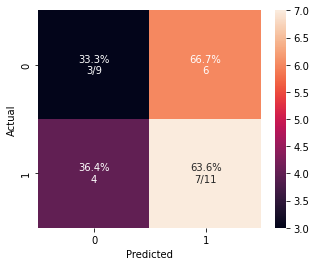

In [45]:
# confusion matrix of QNN
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 
    
cm_analysis(y_test, predicted_y, labels=[0,1], ymap=None, figsize=(5,4)) 

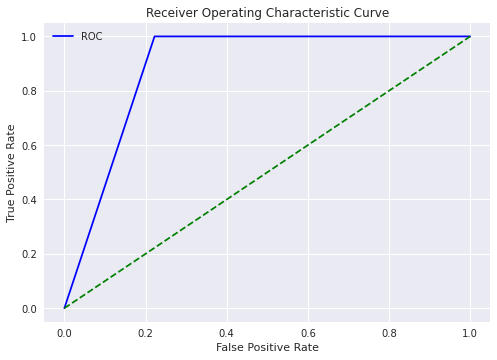

In [46]:
# ROC curve of QNN
plt.style.use('seaborn')

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
fper, tper, thresholds = roc_curve(expected_y, predicted_y)
plot_roc_curve(fper, tper)

## VQC

In [20]:

X = data_n.iloc[:, :-1]  # Select all columns except the last one as features
y= data_n.iloc[:, -1] 


std_scaler = StandardScaler().fit(X)
X = std_scaler.transform(X)
    
pca = PCA(n_components=2).fit(X)
X = pca.transform(X)

minmax_scaler = MinMaxScaler((0, 1)).fit(X)
X = minmax_scaler.transform(X)

# for cross validation
X_df = pd.DataFrame(X)

num_inputs = 2

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

std_scaler = StandardScaler().fit(X_train)
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)
    
pca = PCA(n_components=2).fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

samples = np.append(X_train, X_test, axis=0)
minmax_scaler = MinMaxScaler((0, 1)).fit(samples)
X_train = minmax_scaler.transform(X_train)
X_test = minmax_scaler.transform(X_test)

labels = [0,1]
training_input = {key: (X_train[y_train == k, :]) for k, key in enumerate(labels)}
test_input = {key: (X_test[y_test == k, :]) for k, key in enumerate(labels)}

In [22]:
feature_dim = 2
random_seed = 10489
shots = 1024
backend = BasicAer.get_backend('statevector_simulator')
optimizer = SPSA()
optimizer.set_options(save_steps=1)
feature_map = ZFeatureMap(feature_dimension=feature_dim, reps=2)
var_form = TwoLocal(feature_dim, ['ry', 'rz'], 'cz', reps=3)
vqc = VQC(optimizer, feature_map, var_form, training_input, test_input)
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=random_seed, seed_transpiler=random_seed)

In [23]:
result = vqc.run(quantum_instance)
print("Quantum accuracy on test set: {0}%".format(round(result['testing_accuracy']*100, 2)))

Quantum accuracy on test set: 45.0%


In [24]:
y_test

1216    0
990     0
2594    1
3179    1
965     0
2823    1
2500    1
1459    0
123     0
3454    1
1126    0
3521    1
3843    1
2586    1
3479    1
1988    0
1520    0
3723    1
1333    0
3920    1
Name: label, dtype: int64

In [25]:
y_test

1216    0
990     0
2594    1
3179    1
965     0
2823    1
2500    1
1459    0
123     0
3454    1
1126    0
3521    1
3843    1
2586    1
3479    1
1988    0
1520    0
3723    1
1333    0
3920    1
Name: label, dtype: int64

In [47]:
predicted_y[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [52]:
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def majority_voting(*args):
    # Take the mode (most frequent) prediction across all models
    return np.array([np.argmax(np.bincount(pred)) for pred in np.array(args).T])

ensemble_predictions = majority_voting(y_test, predicted_y[1])


In [53]:
accuracy = accuracy_score(y_test, ensemble_predictions)
print(f'Ensemble Model Accuracy: {accuracy}')


ValueError: Found input variables with inconsistent numbers of samples: [13, 2]

### VQC performance

In [26]:
# classification report of VQC
expected_y  = y_test
predicted_y = vqc.predict(X_test)

# print classification report and confusion matrix for the classifier
print("Classification report: \n", metrics.classification_report(expected_y, predicted_y[1]))
print("Confusion matrix: \n", metrics.confusion_matrix(expected_y, predicted_y[1]))

Classification report: 
               precision    recall  f1-score   support

           0       0.45      1.00      0.62         9
           1       0.00      0.00      0.00        11

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20

Confusion matrix: 
 [[ 9  0]
 [11  0]]


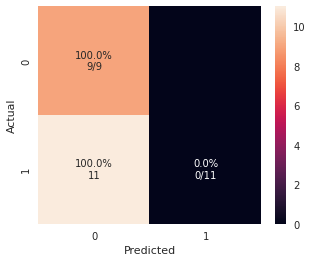

In [27]:
# confusion matrix of VQC
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 
    
cm_analysis(y_test, predicted_y[1], labels=[0,1], ymap=None, figsize=(5,4)) 

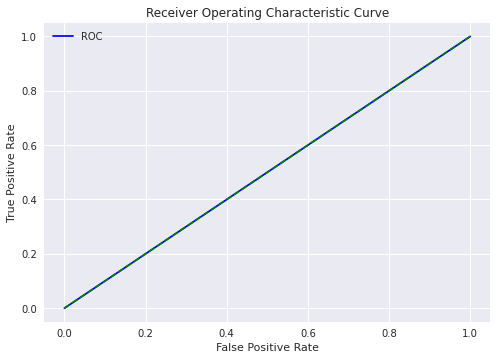

In [52]:
# ROC curve of VQC
plt.style.use('seaborn')

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
fper, tper, thresholds = roc_curve(expected_y, predicted_y[1])
plot_roc_curve(fper, tper)

# Proposed model 

## Bagging-QSVC

In [43]:
# Pipeline Estimator
pipeline = make_pipeline(MinMaxScaler(), qsvc)
# Instantiate the bagging classifier
bgclassifier = BaggingClassifier(base_estimator=pipeline, n_estimators=100, 
                                 random_state=1, n_jobs=-1)
# Fit the bagging classifier
bgclassifier.fit(X_train, y_train)
# Model scores on test and training data
print('Model test Score: %.4f, ' %bgclassifier.score(X_test, y_test),
      'Model training Score: %.4f' %bgclassifier.score(X_train, y_train))

QiskitError: 'Max retry limit reached. Failed to submit the qobj correctly'

### Bagging-QSVC performace

In [61]:
# classification report of Bagging-QSVC
expected_y  = y_test
predicted_y = bgclassifier.predict(X_test) 

# print classification report and confusion matrix for the classifier
print("Classification report: \n", metrics.classification_report(expected_y, predicted_y))
print("Confusion matrix: \n", metrics.confusion_matrix(expected_y, predicted_y))

Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        29
           1       0.91      0.91      0.91        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

Confusion matrix: 
 [[26  3]
 [ 3 29]]


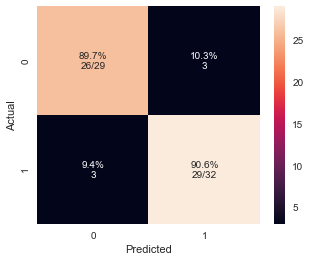

In [62]:
# confusion matrix of Bagging-QSVC
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 
    
cm_analysis(y_test, predicted_y, labels=[0,1], ymap=None, figsize=(5,4)) 

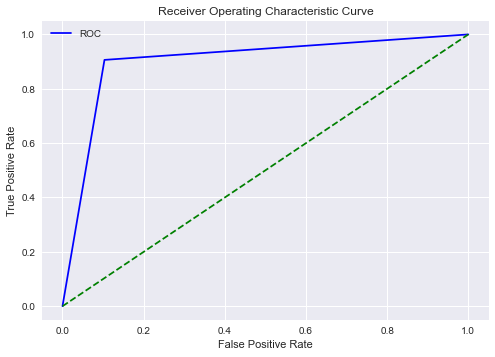

In [63]:
# ROC curve of Bagging-QSVC
from sklearn.metrics import roc_curve
plt.style.use('seaborn')

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
fper, tper, thresholds = roc_curve(expected_y, predicted_y)
plot_roc_curve(fper, tper)